### Gathering Insights from airbnb city data for Seattle and Boston using Data science and Machine Learning

###### 1. How does the average daily listing price trend with day of year?
###### 2. How does listing location relate to monthy listing activity and listing price?
###### 3. What features corelate most to listing price?
###### 4. How can we predict listing prices given entires for features that it relates most to?


In [3]:
#Get all the necessary libraries and modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

import statsmodels.api as sm

import sklearn
from sklearn.model_selection import train_test_split

import os
#from functions import *

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'C:\\code\\Udacity\\airbnb\\ C:\\code'

#### Fetch airbnb city data from the local repository


In [ ]:
#Get Calendar data
calendar = get_airbnb_data('seattle', 'calendar')

calendar.head()

#### Extract pricing information from calendar data 



In [ ]:
#Convert date to pandas datetime format
calendar['date'] = to_date_time(calendar.date)

#Convert price to type float
calendar['price'] = to_numeric(calendar.price)

calendar.head()

#### Visualize pricing trends in relation to time of year

In [ ]:
#For each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

#Decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    #price(time) = Level + Trend(time) + Seasonality(time) + Noise(time) 

#plot oberved time series of property prices
plot_time_series(df.index, df.price)

#plot price trend
plt.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

#### Visualize property price variation in relation to location

- Get geographical plot of Seattle
- Overly with scatter plot of listings
- Contruct 4-D visualization relating listing location (latitude, longitude), number of listing reviews and listing price/day

In [ ]:
#Fetch listings data
listings = get_airbnb_data('seattle', 'listings')

#Extract features to analyze
df = listings[['latitude', 'longitude', 'price', 'reviews_per_month']].copy()

#clean df 
df.dropna(axis=0, inplace=True)
df.price = to_numeric(df.price)

latitudes = df.latitude
longitudes = df.longitude
price_distribution = df.price
activity_distribution = df.reviews_per_month

plot_geographical(latitudes, longitudes, price_distribution, activity_distribution)

#### Preliminary cleaning of Seattle listings data


In [2]:
#Get fresh listings data from Seattle dataset
listings = get_airbnb_data('seattle', 'listings')

#Drop more-than-half-empty columns
is_25_percent_empty = listings.isnull().mean() > 0.25
listings.drop(listings.columns[is_25_percent_empty], axis=1, inplace=True)

#Convert columns to numeric type
for col in ('host_acceptance_rate', 'host_response_rate', 'extra_people', 'price'):
    listings[col] = to_numeric(listings[col])

#drop redundant
listings = drop_cols(listings)

#Drop *_id columns
listings.drop(['scrape_id', 'host_id', 'zipcode'], axis=1, inplace=True)
listings.head()

NameError: name 'get_airbnb_data' is not defined

In [7]:
from sklearn.model_selection import train_test_split

#get the average annual price for each listing from the caledar dataset and insert it into listings dataset
mean_annual_price = calendar.groupby('listing_id')['price'].mean()
listings.set_index('id', inplace=True)
listings.index.name = 'listing_id'
listings['price'] = mean_annual_price
listings.reset_index(inplace=True, drop=True)


X = listings.drop('price', axis=1)
y = listings['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

upper_limit = X_train.price.quantile(0.99)
lower_limit = X_train.price.quantile(0.01)

is_over_limit = X_train.price > upper_limit
is_under_limit = X_train.price < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e6c2b84da3b1>", line 1, in <module>
    from sklearn.model_selection import train_test_split
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\__init__.py", line 19, in <module>
    from ._validation import cross_val_score
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_validation.py", line 27, in <module>
    from ..metrics.scorer import check_scoring, _check_multimetric_scoring
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\__init__.py", line 7, in <module>
    from .ranking import auc
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'C:\\code\\Udacity\\airbnb\\ C:\\code'

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import cr

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)

param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.05, 0.1, 0.15, 0.20], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

model_pipeline = Pipeline([
    ('transform', ct),
    ('grid_search', GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error'))
])

model_pipeline_2 = Pipeline([
    ('transform', ct),
    ('boosted', GradientBoostingRegressor(learning_rate=0.1, n_estimators=200))
])

X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
c_val_score = cross_val_scores(model_pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error') 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-5918d8f9f7c0>", line 3, in <module>
    from sklearn.compose import ColumnTransformer
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\compose\__init__.py", line 8, in <module>
    from ._column_transformer import ColumnTransformer, make_column_transformer
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\compose\_column_transformer.py", line 19, in <module>
    from ..preprocessing import FunctionTransformer
  File "c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\preprocessing\__init__.py", line 6, in <module>
    from ._function_transformer import FunctionTransformer
  File "c:\users\samee\appdata\local\programs\pyth

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'C:\\code\\Udacity\\airbnb\\ C:\\code'

In [136]:
model_pipeline.named_steps['grid_search'].best_params_

{'bootstrap': True, 'max_features': 0.1, 'n_estimators': 120, 'n_jobs': -1}

In [119]:
model_pipeline.named_steps['grid_search'].best_estimator_.score(X_train_transformed, y_train)

0.900367579788913

In [157]:
ohe0 = model_pipeline.named_steps['transform']
ohe1 = ohe0.named_transformers_['cat']
ohe = ohe1.named_steps['ohe']
ohe_cat_cols = ohe.get_feature_names()
num_cols_1 = num_cols.tolist()

ohe_cat_cols = ohe_cat_cols.tolist()
ohe_cat_cols.extend(num_cols_1)

feature_importances = model_pipeline.named_steps['grid_search'].best_estimator_.feature_importances_.tolist()

feature_importances = pd.DataFrame({'features': ohe_cat_cols, 'importance': feature_importances}).set_index('features')

feature_importances.sort_values('importance', ascending=False, inplace=True)

feature_importances.head(n=10)

,importance
features,
host_listings_count,0.052004
accommodates,0.050174
longitude,0.042983
host_total_listings_count,0.041628
latitude,0.040313
reviews_per_month,0.034568
beds,0.033588
availability_365,0.033407
bedrooms,0.032003


In [158]:
X_train_prepared = pd.DataFrame(X_train_transformed, columns=ohe_cat_cols)
X_test_prepared = pd.DataFrame(X_test_transformed, columns=ohe_cat_cols)
mse = np.empty(shape=12)

for i, n_features in enumerate([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]):
    rnd_reg = RandomForestRegressor()
    rnd_reg.set_params = model_pipeline.named_steps['grid_search'].best_params_
    features = feature_importances.index[:n_features]
    X_train_subset = X_train_prepared[features]
    X_test_subset = X_test_prepared[features]
    grid_search.fit(X_train_subset, y_train)
    y_pred = grid_search.best_estimator_.predict(X_test_subset)
    mse[i] = mean_squared_error(y_test, y_pred)

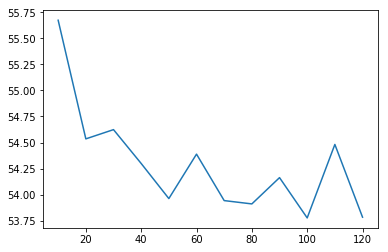

In [159]:
plt.plot(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]), np.sqrt(mse))
plt.show()

In [160]:
from sklearn.linear_model import Ridge

rig_reg = Ridge()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()
extra_reg = ExtraTreesRegressor()

X_train_subset = X_train_prepared[feature_importances.index[:60]]
X_test_subset = X_test_prepared[feature_importances.index[:60]]

mse=[]
for model in (rig_reg, svm_reg, rnd_reg, extra_reg):
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    mse.append(mean_squared_error(y_test, y_pred))
    print(model.score(X_train_subset, y_train))
np.sqrt(mse)

0.3095967576158336


c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.16381229261536834


c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.861706454713601


c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.0


array([56.6733524 , 58.89201621, 57.27735098, 58.96121007])

In [127]:
for i in feature_importances.index[:5]:
    print (i)

accommodates
beds
bedrooms
longitude
host_listings_count


In [ ]:
"""
model_pipeline_2.fit(X_train, y_train)
errors = [mean_squared_error(y_test, y_pred) for y_pred in model_pipeline_2.named_steps['boosted'].staged_predict(ct.transform(X_test))]
bst_n_estimator = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(learning_rate=0.1, n_estimators=bst_n_estimator)
gbrt_best.fit(X_train_transformed, y_train)
y_pred_best = gbrt_best.predict(ct.transform(X_test))
mse = mean_squared_error(y_test, y_pred_best)
np.sqrt(mse)
bst_n_estimator
#model_pipeline.score(X_train, y_train)
""""""

In [11]:
gbrt_best.score(X_train_transformed, y_train)

0.5873738044245775

In [131]:
listings.corr()['price'].sort_values(ascending=False)

price                             1.000000
accommodates                      0.434418
beds                              0.384370
bedrooms                          0.349674
bathrooms                         0.268551
host_total_listings_count         0.266230
host_listings_count               0.266230
guests_included                   0.236563
review_scores_cleanliness         0.071001
availability_90                   0.068590
review_scores_location            0.068029
availability_60                   0.066057
availability_30                   0.058425
availability_365                  0.057620
calculated_host_listings_count    0.044967
host_response_rate                0.040946
review_scores_rating              0.024264
review_scores_communication       0.008091
host_acceptance_rate             -0.001849
review_scores_checkin            -0.002324
number_of_reviews                -0.007088
minimum_nights                   -0.008325
review_scores_accuracy           -0.009541
maximum_nig

In [36]:
calendar.head()

,listing_id,date,available,year,month,month_name,price
0,241032,2016-01-04,t,2016,1,January,85.0
1,241032,2016-01-05,t,2016,1,January,85.0
2,241032,2016-01-06,f,2016,1,January,NaN
3,241032,2016-01-07,f,2016,1,January,NaN
4,241032,2016-01-08,f,2016,1,January,NaN


In [16]:
select_features = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
           'host_is_superhost', 'host_total_listings_count', 'property_type', 'room_type', 'accommodates',
           'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews',
           'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count',
           'reviews_per_month']

listings_model = listings[select_features]

In [17]:
X = listings_model.drop('price', axis=1)
y = listings_model['price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)

model_pipeline = Pipeline([
    ('transform', ct),
    ('lin_reg', LinearRegression())
])

X_train_prepared = ct.fit_transform(X_train)
pl = ct.named_transformers_['cat']
ohe = pl.named_steps['ohe']
columns = ohe.get_feature_names()

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)
model_pipeline.score(X_train, y_train)

0.40072323198376214

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import FeatureUnion

num_cols = X_train.select_dtypes(exclude=['object']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        self.encoder = MultiLabelBinarizer(sparse_output=self.sparse_output)
        self.encoder.fit(X)
        return self
    def transform(self, X, y=None):
        return self.encoder.transform(X)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_cols)),
    ('impute', Imputer(strategy='mean')),
    ('std_scalar', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_cols)),
    ('encoder', CustomLabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

listing_prepared = full_pipeline.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(listing_prepared, y_train)
X_test_prepared = full_pipeline.transform(X_test)
y_pred = lin_reg.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

c:\users\samee\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


TypeError: '<' not supported between instances of 'str' and 'float'

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

lin_reg, tree_reg, svm_reg, forrest_reg, knn_reg = LinearRegression(), DecisionTreeRegressor(), SVR(), RandomForestRegressor(n_estimators=500, n_jobs=-1), KNeighborsRegressor()

rmse = []
for reg in (lin_reg, tree_reg, svm_reg, forrest_reg, knn_reg):
    reg.fit(listing_prepared, y_train)
    y_pred = reg.predict(full_pipeline.fit_transform(X_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(rmse)

67.0852780925826
101.17972684135444
77.75762294026599
69.1303487374605
74.05644656265186


In [41]:
df = pd.DataFrame({'features': num_cols, 'importances': lin_reg.coef_})

In [56]:
listings_model.groupby('room_type')['price'].mean()

room_type
Entire home/apt    94.578906
Private room       51.171552
Shared room        28.931624
Name: price, dtype: float64

In [55]:
df.sort_values('importances', ascending=False)

,features,importances
70,Entire home/apt,6.502896e+13
125,Private room,6.502896e+13
104,Shared room,6.502896e+13
143,Beverly Hills,3.028004e+02
85,Fenway/Kenmore,2.169781e+02
135,Boat,1.547608e+02
139,Chalet,1.327858e+02
103,East Village,1.214721e+02
51,Bed & Breakfast,1.134286e+02
93,Manhattan Beach,8.849096e+01


In [139]:
listings.price.std()

80.88252864602697

In [16]:
listings.neighbourhood.unique().shape[0]

82

In [32]:
listings.price

AttributeError: 'DataFrame' object has no attribute 'price'

In [38]:
listings['price']

KeyError: 'price'

In [97]:
listings[['id', 'price']].head()

,id,price
0,241032,85.0
1,953595,15.0
2,3308979,975.0
3,7421966,1.0
4,278830,45.0


listings[['id', 'price']].head()

In [50]:
listings.id.head()

0     241032
1     953595
2    3308979
3    7421966
4     278830
Name: id, dtype: int64

In [94]:
calendar = get_airbnb_data('seattle', calendar=True, listings=False, reviews=False)[0]

In [95]:
calendar = pd.concat([calendar.drop('price', axis=1), calendar['price'].replace('[\$,]', '', regex=True).str.rstrip('.0').astype(np.float)], axis=1)

In [96]:
df = calendar.groupby('listing_id')['price'].median().reset_index()

In [98]:
df.price[df.listing_id==7421966]

2512    1.0
Name: price, dtype: float64

In [184]:
mdates.DateFormatter?

In [40]:
calendar.groupby('listing_id')['price'].mean()[953595]

155.8384879725086

In [10]:
listings.head()

,host_response_time,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,...,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_response_rate,host_acceptance_rate,price
0,within a few hours,f,3.0,t,t,Queen Anne,47.636289,-122.371025,t,Apartment,...,10.0,f,moderate,f,f,2,4.07,96.0,100.0,85.000000
1,within an hour,t,6.0,t,t,Queen Anne,47.639123,-122.365666,t,Apartment,...,10.0,f,strict,t,t,6,1.48,98.0,100.0,155.838488
2,within a few hours,f,2.0,t,t,Queen Anne,47.629724,-122.369483,t,House,...,10.0,f,strict,f,f,2,1.15,67.0,100.0,402.636364
3,NaN,f,1.0,t,t,Queen Anne,47.638473,-122.369279,t,Apartment,...,NaN,f,flexible,f,f,1,NaN,NaN,NaN,1.000000
4,within an hour,f,2.0,t,t,Queen Anne,47.632918,-122.372471,t,House,...,9.0,f,strict,f,f,1,0.89,100.0,NaN,152.030137


In [34]:
calendar.groupby('listing_id')['price'].mean()[6606]

6.720547945205479

In [79]:
y_pred

array([81., 54., 39., ..., 65.,  5., 45.])

In [80]:
y_test

2116     15.000000
3343     95.000000
1831     41.000000
3421    165.000000
2113      5.000000
185     279.336986
3033     37.368715
3657     83.721591
2978     10.252747
1343    149.492248
3110     65.000000
93       52.941818
1882     70.134831
2887    141.836795
109     135.000000
2657     53.289474
1267    234.931232
1368    404.715190
1835     44.206349
750      11.000000
766      43.441860
370      42.350000
1096     13.015106
3111      6.857550
2573    128.255814
197      96.189802
2025    125.000000
2633    108.138889
325      65.000000
323     117.832861
           ...    
3117    105.000000
3466     49.000000
23       75.000000
3197    310.705202
159     139.060606
1788     79.000000
878     171.893617
2501     43.571429
920      93.130435
355      59.000000
1255     18.000000
2862     19.117318
450      46.000000
3737    117.888889
768       7.000000
1777     65.312849
942      11.295890
1703    160.428571
3779     67.105714
3614    125.000000
313       4.000000
1406    240.

In [88]:
cat_cols

array(['x0_MISSING', 'x0_a few days or more', 'x0_within a day',
       'x0_within a few hours', 'x0_within an hour', 'x1_MISSING', 'x1_f',
       'x1_t', 'x2_MISSING', 'x2_f', 'x2_t', 'x3_MISSING', 'x3_f', 'x3_t',
       'x4_Ballard', 'x4_Beacon Hill', 'x4_Capitol Hill', 'x4_Cascade',
       'x4_Central Area', 'x4_Delridge', 'x4_Downtown', 'x4_Interbay',
       'x4_Lake City', 'x4_Magnolia', 'x4_Northgate',
       'x4_Other neighborhoods', 'x4_Queen Anne', 'x4_Rainier Valley',
       'x4_Seward Park', 'x4_University District', 'x4_West Seattle',
       'x5_f', 'x5_t', 'x6_Apartment', 'x6_Bed & Breakfast', 'x6_Boat',
       'x6_Bungalow', 'x6_Cabin', 'x6_Camper/RV', 'x6_Chalet',
       'x6_Condominium', 'x6_Dorm', 'x6_House', 'x6_Loft', 'x6_MISSING',
       'x6_Other', 'x6_Tent', 'x6_Townhouse', 'x6_Treehouse',
       'x7_Entire home/apt', 'x7_Private room', 'x7_Shared room',
       'x8_Airbed', 'x8_Couch', 'x8_Futon', 'x8_Pull-out Sofa',
       'x8_Real Bed', 'x9_$0.00', 'x9_$10.00', 

In [89]:
cat_cols

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'extra_people', 'calendar_updated', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [103]:
print(X_train_transformed)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ... -5.05822017e-01
   0.00000000e+00  7.75662942e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.06488565e+00
   4.62913651e-01  2.27426780e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.39383898e-01
   4.62913651e-01  2.27426780e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -7.36739603e-01
   4.62913651e-01  2.27426780e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  2.69863180e-16
  -3.65981183e+00  2.27426780e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -4.63284567e-01
  -1.36940879e+00  2.27426780e-02]]


In [138]:
og = model_pipeline.named_steps['grid_search']

In [139]:
be = og.best_estimator_

In [148]:
pd.Series(be.feature_importances_)
oh = model_pipeline.named_steps['transform'].named_transformers_['cat'].named_steps['ohe']
cat_cols_modified = oh.get_feature_names()

In [166]:
cat_cols_modified = cat_cols_modified.tolist()

In [168]:
cat_cols_modified.extend(num_cols)

In [169]:
cat_cols_modified

['x0_MISSING',
 'x0_a few days or more',
 'x0_within a day',
 'x0_within a few hours',
 'x0_within an hour',
 'x1_MISSING',
 'x1_f',
 'x1_t',
 'x2_MISSING',
 'x2_f',
 'x2_t',
 'x3_MISSING',
 'x3_f',
 'x3_t',
 'x4_Ballard',
 'x4_Beacon Hill',
 'x4_Capitol Hill',
 'x4_Cascade',
 'x4_Central Area',
 'x4_Delridge',
 'x4_Downtown',
 'x4_Interbay',
 'x4_Lake City',
 'x4_Magnolia',
 'x4_Northgate',
 'x4_Other neighborhoods',
 'x4_Queen Anne',
 'x4_Rainier Valley',
 'x4_Seward Park',
 'x4_University District',
 'x4_West Seattle',
 'x5_Phinney Ridge Seattle',
 'x5_Seattle',
 'x5_Seattle ',
 'x5_West Seattle',
 'x5_seattle',
 'x5_西雅图',
 'x6_WA',
 'x6_wa',
 'x7_Phinney Ridge Seattle, WA',
 'x7_Seattle , WA',
 'x7_Seattle, WA',
 'x7_West Seattle, WA',
 'x7_seattle, wa',
 'x7_西雅图, WA',
 'x8_f',
 'x8_t',
 'x9_Apartment',
 'x9_Bed & Breakfast',
 'x9_Boat',
 'x9_Bungalow',
 'x9_Cabin',
 'x9_Camper/RV',
 'x9_Chalet',
 'x9_Condominium',
 'x9_Dorm',
 'x9_House',
 'x9_Loft',
 'x9_MISSING',
 'x9_Other',
 '

In [163]:
num_cols.shape

(27,)

In [171]:
listings.extra_people.value_counts()

$0.00      2003
$10.00      347
$25.00      312
$20.00      301
$15.00      300
$50.00      105
$30.00       84
$5.00        56
$40.00       36
$35.00       34
$100.00      16
$75.00       14
$7.00        12
$45.00       10
$29.00        9
$12.00        8
$8.00         8
$60.00        8
$18.00        6
$19.00        5
$17.00        5
$9.00         5
$14.00        4
$6.00         4
$28.00        3
$80.00        3
$55.00        3
$49.00        2
$22.00        2
$300.00       2
$200.00       2
$21.00        1
$44.00        1
$250.00       1
$27.00        1
$13.00        1
$48.00        1
$16.00        1
$26.00        1
$71.00        1
$85.00        1
$68.00        1
$33.00        1
$175.00       1
$36.00        1
Name: extra_people, dtype: int64

In [180]:
listings.price.head()

AttributeError: 'DataFrame' object has no attribute 'price'